# Modèles TensorFlow - Classification et Régression

Ce notebook implémente deux modèles avec TensorFlow/Keras :
- **Classification** : Prédire si un étudiant va compléter le cours (`Completed`).
- **Régression** : Prédire les scores et la satisfaction (`Quiz_Score_Avg`, `Project_Grade`, `Satisfaction_Rating`, `Time_Spent_Hours`).

In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

## 1. Chargement des données

In [38]:
# Chargement des fichiers exportés
X_class = pd.read_csv('../data/processed/X_classification.csv')
y_class = pd.read_csv('../data/processed/y_classification.csv')

X_reg = pd.read_csv('../data/processed/X_regression.csv')
y_reg = pd.read_csv('../data/processed/y_regression.csv')

print("Datasets chargés successfully.")
print(f"Classification : X={X_class.shape}, y={y_class.shape}")
print(f"Régression : X={X_reg.shape}, y={y_reg.shape}")

Datasets chargés successfully.
Classification : X=(56172, 42), y=(56172, 1)
Régression : X=(56172, 37), y=(56172, 4)


## 2. PARTIE 1 : CLASSIFICATION
---

Objectif : Prédire la colonne `Completed` (0 ou 1).

In [39]:
# Split des données
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class.values, y_class.values.ravel(), test_size=0.15, random_state=42
)

In [40]:
# Création du modèle de classification (simplifié pour éviter l'overfitting)
model_class = Sequential([
    Input(shape=(X_train_c.shape[1],)),
    
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_class.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_class.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,769 (65.50 KB)

 Trainable params: 16,321 (63.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
# Callbacks pour stabiliser l'apprentissage
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30, # Arrêt si aucune amélioration après 30 époques
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,   # Divise le LR par 5 si on stagne
        patience=10,  # Après 10 époques sans progrès
        min_lr=1e-6,
        verbose=1
    )
]
history_class = model_class.fit(
    X_train_c, y_train_c, 
    epochs=500, 
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
597/597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5535 - loss: 0.7066 - val_accuracy: 0.5959 - val_loss: 0.6664 - learning_rate: 0.0010
Epoch 2/500
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5852 - loss: 0.6727 - val_accuracy: 0.5993 - val_loss: 0.6655 - learning_rate: 0.0010
Epoch 3/500
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5959 - loss: 0.6656 - val_accuracy: 0.5965 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 4/500
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6061 - loss: 0.6615 - val_accuracy: 0.6026 - val_loss: 0.6640 - learning_rate: 0.0010
Epoch 5/500
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6039 - loss: 0.6606 - val_accuracy: 0.6015 - val_loss: 0.6640 - learning_rate: 0.0010
Epoch 6/500
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6031 - loss: 0.6599 - val_accuracy: 0.5983 - val_loss: 0.6633 - learning_rate: 0.0010
Epoch 7/500
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6058 - loss: 0.

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.6125 - loss: 0.6553

Accuracy sur le Test Set : 0.6125


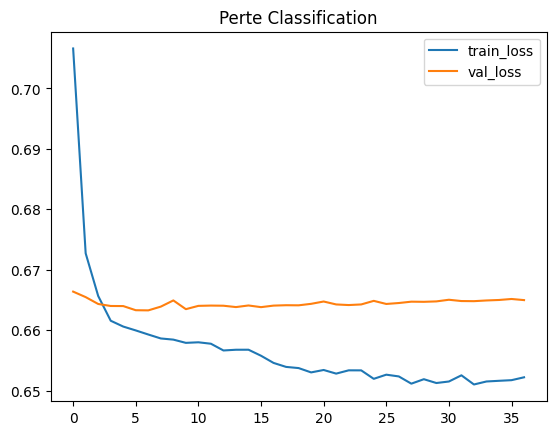

In [42]:
# Évaluation Classification
loss_c, acc_c = model_class.evaluate(X_test_c, y_test_c)
print(f"\nAccuracy sur le Test Set : {acc_c:.4f}")

# Plot
plt.plot(history_class.history['loss'], label='train_loss')
plt.plot(history_class.history['val_loss'], label='val_loss')
plt.title('Perte Classification')
plt.legend()
plt.show()

## 3. PARTIE 2 : RÉGRESSION
---

Objectif : Prédire les 4 variables continues simultanément.

In [43]:
# Split des données
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg.values, y_reg.values, test_size=0.15, random_state=42
)

In [44]:
model_reg = Sequential([
    Input(shape=(X_train_r.shape[1],)),
    
    Dense(256),
    BatchNormalization(),
    Activation('swish'),
    Dropout(0.3),
    
    Dense(128),
    BatchNormalization(),
    Activation('swish'),
    Dropout(0.2),
    
    Dense(64),
    BatchNormalization(),
    Activation('swish'),
    Dropout(0.1),
    
    Dense(32, activation='swish'),
    Dense(4) # Sortie pour les 4 cibles
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_reg.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model_reg.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,884 (214.39 KB)

 Trainable params: 53,988 (210.89 KB)

 Non-trainable params: 896 (3.50 KB)

In [45]:
# Entraînement
history_reg = model_reg.fit(
    X_train_r, y_train_r, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.1,
    callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=30,
        min_lr=1e-6,
        verbose=1
    )
    ],
    verbose=1
)

Epoch 1/50
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 368.9744 - mae: 10.4701 - val_loss: 101.5248 - val_mae: 6.5298 - learning_rate: 0.0010
Epoch 2/50
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 114.2868 - mae: 6.8817 - val_loss: 100.5738 - val_mae: 6.4981 - learning_rate: 0.0010
Epoch 3/50
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 109.1454 - mae: 6.7365 - val_loss: 94.9457 - val_mae: 6.3391 - learning_rate: 0.0010
Epoch 4/50
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 91.9919 - mae: 6.2006 - val_loss: 62.1593 - val_mae: 5.1353 - learning_rate: 0.0010
Epoch 5/50
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 67.6065 - mae: 5.3287 - val_loss: 50.5855 - val_mae: 4.5692 - learning_rate: 0.0010
Epoch 6/50
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 59.3429 - mae: 4.9886 - val_loss: 46.2053 - val_mae: 4.1434 - learning_rate: 0.0010
Epoch 7/50
1343/1343 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 55.4466 - mae: 4.8048 - val_loss: 47.8538 - val_mae: 4.3

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Quiz_Score_Avg -> RMSE: 12.3488, R2: 0.0484
Project_Grade -> RMSE: 1.6496, R2: 0.9884
Satisfaction_Rating -> RMSE: 0.7251, R2: -0.0515
Time_Spent_Hours -> RMSE: 3.6815, R2: 0.0553


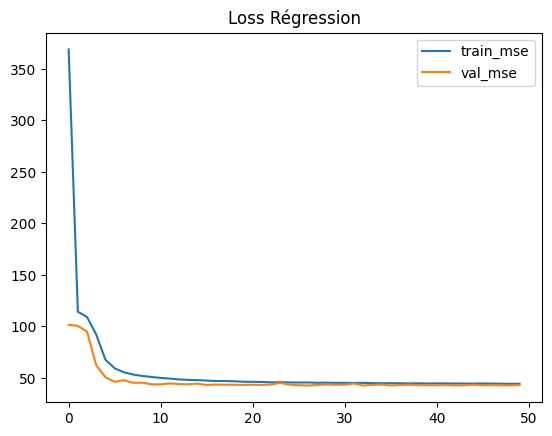

In [46]:
# Évaluation Régression
y_pred_r = model_reg.predict(X_test_r)

# Pas d'inverse_transform car les y ne sont pas normalisés
y_pred_orig = y_pred_r
y_test_orig = y_test_r

target_names = ['Quiz_Score_Avg', 'Project_Grade', 'Satisfaction_Rating', 'Time_Spent_Hours']
for i, name in enumerate(target_names):
    rmse = np.sqrt(mean_squared_error(y_test_orig[:, i], y_pred_orig[:, i]))
    r2 = r2_score(y_test_orig[:, i], y_pred_orig[:, i])
    print(f"{name} -> RMSE: {rmse:.4f}, R2: {r2:.4f}")

# Plot Loss Régression
plt.plot(history_reg.history['loss'], label='train_mse')
plt.plot(history_reg.history['val_loss'], label='val_mse')
plt.title('Loss Régression')
plt.legend()
plt.show()